<font color='#3399FF' face='Tahoma' size=6>Análisis Bivariado |  Base 7 días</font>

In [137]:
import sys
sys.path.append('/workspaces/atrato-data-ds-collection-score')

In [138]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import bisect
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from collections import Counter
from tabulate import tabulate

In [140]:
from src.tools.features import *
from src.tools.utils import *
from src.tools.bivariados_7 import *

In [141]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [142]:
df = pd.read_csv('../../../data_no_dvc/BASE_7_DIAS_CORRECIONES_2025-01-10.csv')
calificar_1 = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION7DIAS_ASIGNACION_2024-12-02.csv')
calificar_2 = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION7DIAS_ASIGNACION_2024-11-15.csv')
calificar_3 = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION7DIAS_ASIGNACION_2024-11-01.csv')
calificar_4 = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION7DIAS_ASIGNACION-2024-10-15.csv')
calificar = pd.concat([calificar_1, calificar_2, calificar_3, calificar_4], axis=0)
solicitudes_validation = list(calificar['idobservation'].values)
df = df[~df['idobservation'].isin(solicitudes_validation)]

In [143]:
len(df)

94422

In [144]:
df['target_7_days'].value_counts()

target_7_days
0    55140
1    39282
Name: count, dtype: int64

In [145]:
df['target_7_days'].value_counts(normalize=True)

target_7_days
0    0.583974
1    0.416026
Name: proportion, dtype: float64

In [146]:
# Calculo de variables de payment-history
df_con_payment_history = df[~df['payment_history'].isna()]
resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)

In [147]:
df = pd.merge(df, resultados.iloc[:,1:], how='left', on='idobservation')

In [148]:
#Se calcula target para experimento y se borra el que se usa para construirlo
df['target_bucket'] = df.apply(lambda row: 0 if row['target_7_days'] == 0 else (1 if row['target_7_days']==1 and row['target_52_days']==0 else 2), axis=1)
#Se calculan features que sustituyen algunas directas.
df['max_overdue_amount_to_monthly_payment_ratio'] = df['max_overdue_amount']/df['montlhy_payment']

In [149]:
# Primero llenamos los nulos de pct_credit_maturity con 0
df['pct_credit_maturity'].fillna(0, inplace=True)

# Despues se eliminan los datos que se detectaron como outliers como EDA
df = df[df['pct_credit_maturity']<1]

del df['pct_credit_maturity']

df = df[~(df['risk_profile_v2']=='ERROR')]

df['num_atrato_credits'].fillna(1, inplace=True)

In [150]:
# funciones diseñadas (Bivariados)
df.loc[(df['payments_before_worst_overdue'].isna())&(~df['payment_history'].isna()), 'payments_before_worst_overdue']  = df.loc[(df['payments_before_worst_overdue'].isna())&(~df['payment_history'].isna())].apply(lambda row: payments_before_worst_overdue_null(row['payment_history']), axis=1)
df.loc[(df['payments_before_first_overdue'].isna())&(~df['payment_history'].isna()), 'payments_before_first_overdue']  = df.loc[(df['payments_before_first_overdue'].isna())&(~df['payment_history'].isna())].apply(lambda row: payments_before_first_overdue_null(row['payment_history']), axis=1)
df.loc[(df['ratio_overdue_payments'].isna())&(~df['payment_history'].isna()), 'ratio_overdue_payments']  = df.loc[(df['ratio_overdue_payments'].isna())&(~df['payment_history'].isna())].apply(lambda row: ratio_overdue_payments_null(row['payment_history'], row['monthly_payment_terms']), axis=1)

In [151]:
len(df)

94421

In [152]:
df['target_7_days'].value_counts()

target_7_days
0    55140
1    39281
Name: count, dtype: int64

In [153]:
df['target_7_days'].value_counts(normalize=True)

target_7_days
0    0.58398
1    0.41602
Name: proportion, dtype: float64

In [154]:
'''features_list = ['ratio_overdue_payments',
                 'granted_credit_amount',
                 'risk_profile_v2',
                 'num_atrato_credits',
                 'early_settled_atrato_credits',
                 'monthly_payment_terms',
                 'age',
                 'gender',
                 'payments_before_first_overdue',
                 'payments_before_worst_overdue',
                 'days_of_worst_overdue',
                 'current_debt',
                 'dashboard_inquiries',
                 'most_used_paymentmethod',
                 'owed_amount_cc',
                 'num_expected_payments_monthly',
                 'current_credit_delay_trend',
                 'average_current_credit_delay',
                 'avg_period_between_overdue',
                 'max_overdue_amount_to_monthly_payment_ratio']'''

target = 'target_7_days'

In [155]:
## ELIMINADO DE VARIABLES
# no hay suficiente info , alto volumen de nulos
del df['payment_promise_amount']
del df['payment_promise']
del df['sub7_days_delays_count']
del df['epdscore']

# no muestran importancia o sensibilidad
del df['max_overdue']
del df['max_overdue_amount']
del df['montlhy_payment']
del df['risk_profile_v1']
del df['historical_overdue_atrato_credits']
del df['sum_credits_was_late']

# alta corr con originales
del df['paid_late_commission_amount_user']
del df['pending_late_commission_amount_user']
del df['paid_late_commission_amount']
del df['pending_late_commission_amount']

##del df['has_mortgage_or_large_loans'] 
del df['has_mortgage_overdue'] 

del df['target_52_days']

# no sensibilidad
del df['gender']



In [156]:
features_list = list(df.columns)

In [157]:
len(features_list)

33

In [158]:
get_missing_report(df[features_list])

,columns,missingPercentage,type
14,has_mortgage_or_large_loans,85.749992,float64
8,early_settled_atrato_credits,84.637951,float64
17,most_used_paymentmethod,78.936889,object
32,max_overdue_amount_to_monthly_payment_ratio,26.443270,float64
13,days_of_worst_overdue,26.443270,float64
16,dashboard_inquiries,25.609769,float64
23,current_credit_delay_trend,14.135627,float64
30,num_bucket_3,14.135627,float64
29,num_bucket_2,14.135627,float64
3,payment_history,14.135627,object


In [159]:
df_bivariados = df.copy()
df_sin_nulos = df.copy()

## <font face='Monaco' color='#70b8db' size=4>ratio_overdue_payments</font>

In [160]:
df['ratio_overdue_payments'].describe()

count    81605.000000
mean         0.255847
std          0.210176
min          0.000000
25%          0.083000
50%          0.208000
75%          0.361000
max          1.500000
Name: ratio_overdue_payments, dtype: float64

In [161]:
df['ratio_overdue_payments'].isnull().sum()/len(df)*100

13.573251713072304

In [162]:
IQR = df['ratio_overdue_payments'].describe()[6]-df['ratio_overdue_payments'].describe()[4]
rango = [df['ratio_overdue_payments'].describe()[4]-IQR*1.5, df['ratio_overdue_payments'].describe()[6]+IQR*1.5]
print(rango)

[-0.3339999999999999, 0.7779999999999999]


Correlación: -0.044656858919770115 
 Covarianza: -0.0045586081194435935
Porcentaje total:  86.4267482869277
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


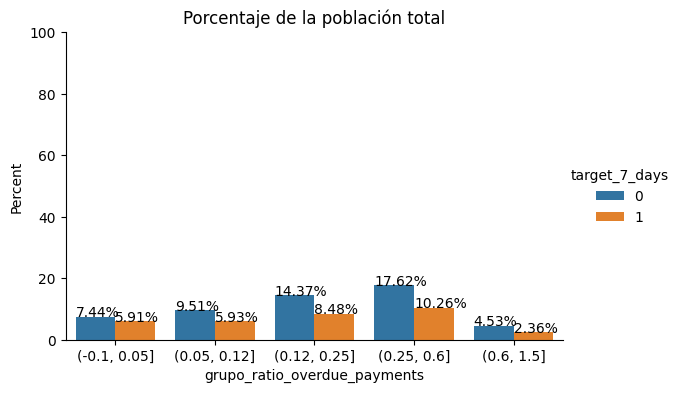

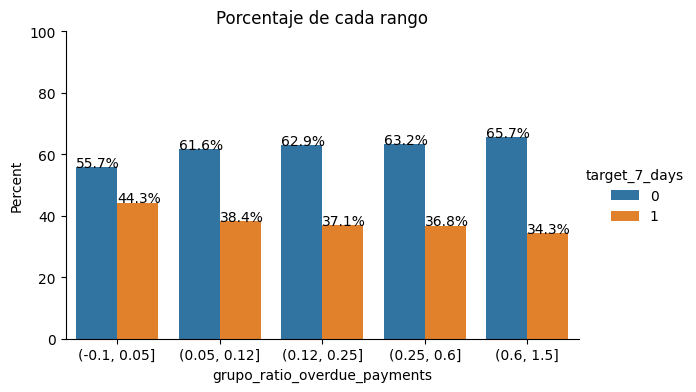

In [163]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [-0.1,0.05,0.12,0.25,0.6,df_bivariados['ratio_overdue_payments'].max()], False)

<font face='Verdana' size=3>NULL --> 0 ? </font>

In [164]:
df_sin_nulos_a = df_sin_nulos.copy()

In [165]:
df_sin_nulos_a['ratio_overdue_payments'].fillna(0, inplace=True)

Correlación: -0.044656858919770115 
 Covarianza: -0.0045586081194435935
Porcentaje total:  86.4267482869277
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


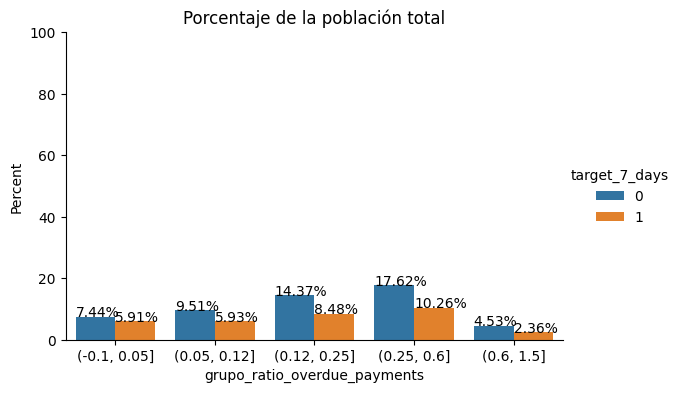

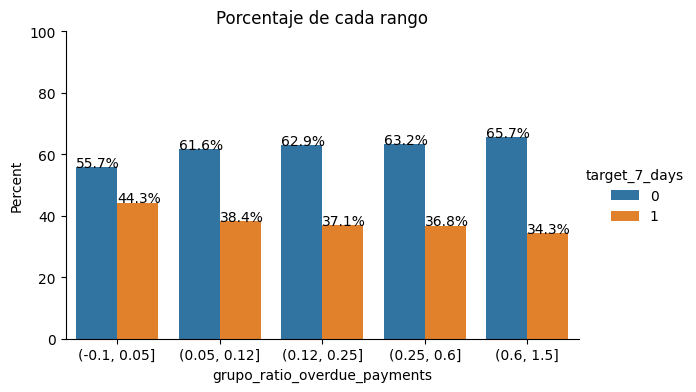

In [166]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [-0.1,0.05,0.12,0.25,0.6,df_bivariados['ratio_overdue_payments'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [167]:
df_sin_nulos_b = df_sin_nulos.copy()

In [168]:
df_sin_nulos_b['ratio_overdue_payments'].median()

0.208

In [169]:
df_sin_nulos_b['ratio_overdue_payments'].fillna(0.2, inplace=True)

Correlación: -0.044656858919770115 
 Covarianza: -0.0045586081194435935
Porcentaje total:  86.4267482869277
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


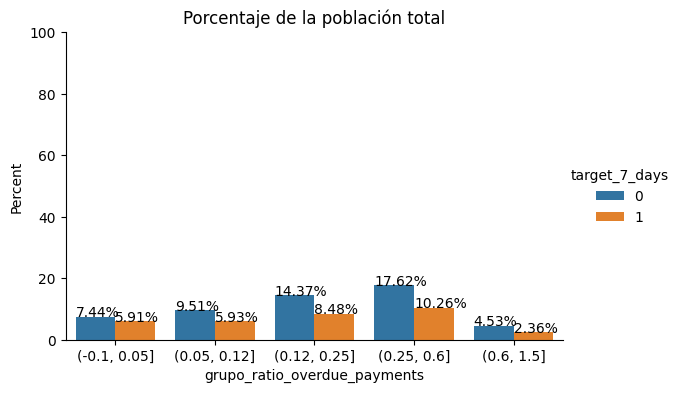

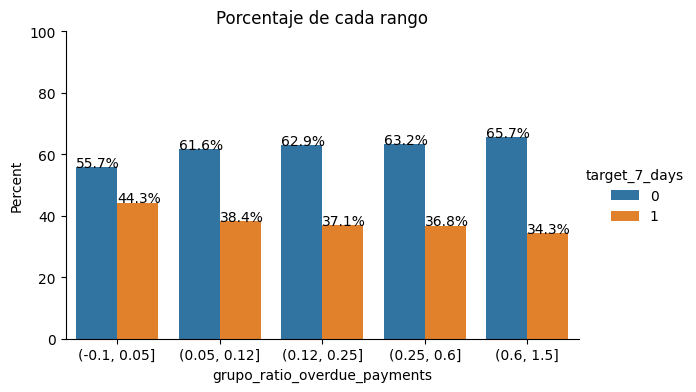

In [170]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [-0.1,0.05,0.12,0.25,0.6,df_bivariados['ratio_overdue_payments'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [171]:
df_sin_nulos_c = df_sin_nulos.copy()

In [172]:
df_sin_nulos_c['ratio_overdue_payments'].mean()

0.25584661206761566

In [173]:
df_sin_nulos_c['ratio_overdue_payments'].fillna(0.25, inplace=True)

Correlación: -0.044656858919770115 
 Covarianza: -0.0045586081194435935
Porcentaje total:  86.4267482869277
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


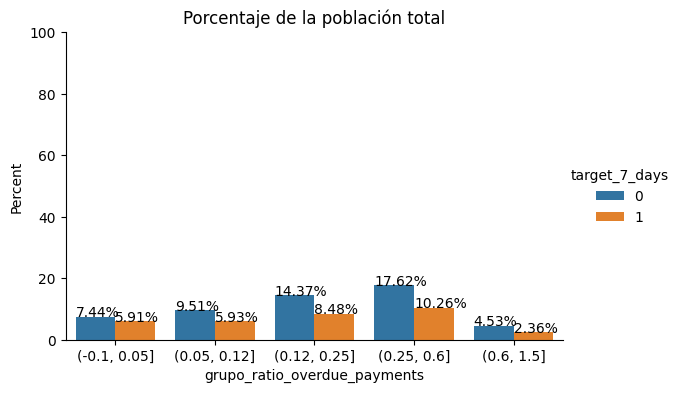

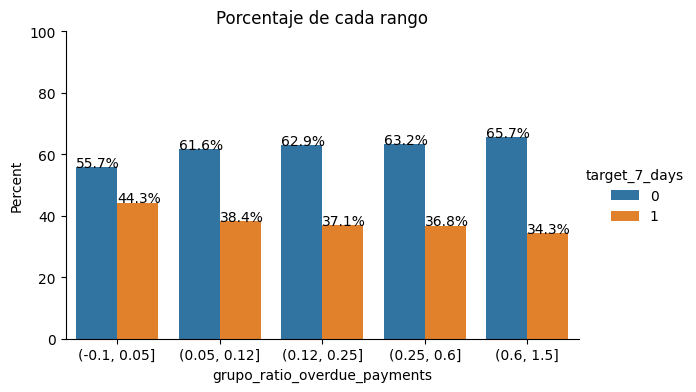

In [174]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [-0.1,0.05,0.12,0.25,0.6,df_bivariados['ratio_overdue_payments'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Distribución y tendencia decreciente se ve mejor con MEDIANA (0.2)</font>

## <font face='Monaco' color='#70b8db' size=4>granted_credit_amount</font>

In [175]:
df['granted_credit_amount'].describe()

count     94421.000000
mean      14339.603537
std       13647.332187
min         491.000000
25%        5500.000000
50%       10000.000000
75%       18000.000000
max      200000.000000
Name: granted_credit_amount, dtype: float64

In [176]:
df['granted_credit_amount'].isnull().sum()/len(df)*100

0.0

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>NO NULOS: </font> variable no contiene nulos</font>

## <font face='Monaco' color='#70b8db' size=4>risk_profile_v2</font>

In [177]:
df['risk_profile_v2'].describe()

count     91035
unique        7
top          D1
freq      15352
Name: risk_profile_v2, dtype: object

In [178]:
df['risk_profile_v2'].value_counts()

risk_profile_v2
D1    15352
B2    15275
C2    14168
C1    13442
B1    12550
A2    12164
A1     8084
Name: count, dtype: int64

In [179]:
df['risk_profile_v2'].isnull().sum()/len(df)*100

3.5860666589000325

In [180]:
# mapeamos PR2 a numero
ordinal_map_PR2 = {'A1': 1,'A2': 2,'B1': 3,'B2': 4, 'C1':5, 'C2':6, 'D1':7}
df_bivariados['risk_profile_v2'] = df_bivariados['risk_profile_v2'].map(ordinal_map_PR2)


In [181]:
df['risk_profile_v2'].isnull().sum()/len(df)*100

3.5860666589000325

Correlación: 0.12508154705977276 
 Covarianza: 0.11816603596697928
Porcentaje total:  96
Relación de target_7_days nulos:
	 1s:58.446544595392794 (1979)
	 0s:41.553455404607206 (1407)


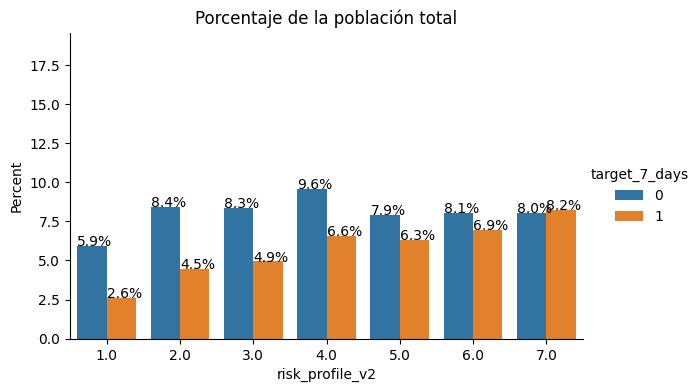

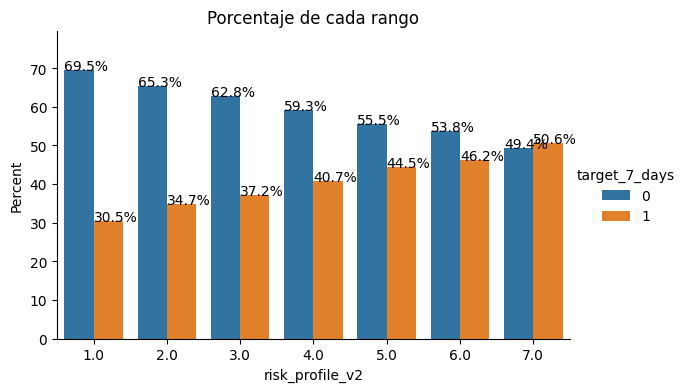

In [182]:
AnalisisBivariado(df_bivariados, 'risk_profile_v2', None, True)

<font face='Verdana' size=3>NULL --> llenamos null con 3 : 'B1'</font>

In [183]:
# mapeamos PR2 a numero
ordinal_map_PR2 = {'A1': 1,'A2': 2,'B1': 3,'B2': 4, 'C1':5, 'C2':6, 'D1':7}
df_sin_nulos['risk_profile_v2'] = df_sin_nulos['risk_profile_v2'].map(ordinal_map_PR2)

In [184]:
df_sin_nulos['risk_profile_v2'].fillna(3, inplace=True)

Correlación: 0.1218524822572416 
 Covarianza: 0.11395098147329842
Porcentaje total:  100


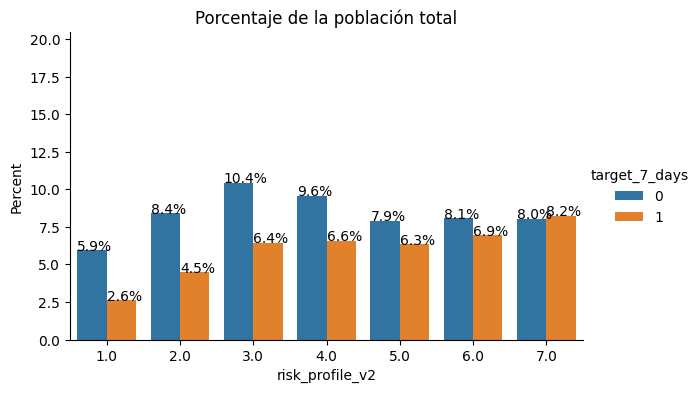

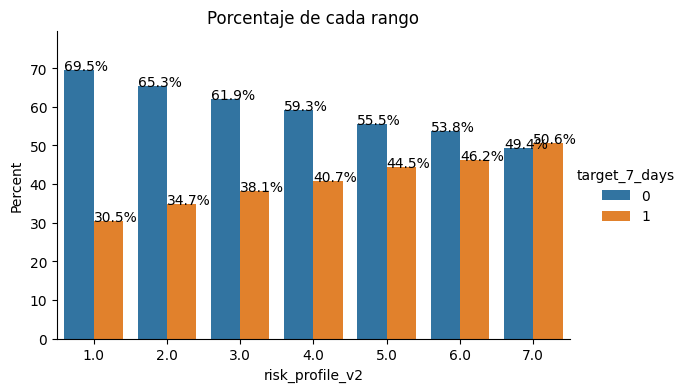

In [185]:
AnalisisBivariado(df_sin_nulos, 'risk_profile_v2', None, True)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Se lklenan nulos con valor 3, equivalente a PR2 _B1_ para conservar tendencia creciente de 1s en target conforme aumenta el PR2</font>

## <font face='Monaco' color='#70b8db' size=4>num_atrato_credits</font>

In [186]:
df['num_atrato_credits'].describe()

count    94421.000000
mean         1.796708
std          1.173143
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
Name: num_atrato_credits, dtype: float64

In [187]:
df['num_atrato_credits'].isnull().sum()/len(df)*100

0.0

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>NO NULOS: </font> variable no contiene nulos</font>

## <font face='Monaco' color='#70b8db' size=4>early_settled_atrato_credits</font>

In [188]:
df['early_settled_atrato_credits'].describe()

count    14505.000000
mean         1.463357
std          0.875085
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: early_settled_atrato_credits, dtype: float64

In [189]:
df['early_settled_atrato_credits'].isnull().sum()/len(df)*100

84.63795130320585

In [190]:
IQR = df['early_settled_atrato_credits'].describe()[6]-df['early_settled_atrato_credits'].describe()[4]
rango = [df['early_settled_atrato_credits'].describe()[4]-IQR*1.5, df['early_settled_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


Correlación: -0.007078193000568177 
 Covarianza: -0.0029890029742301477
Porcentaje total:  15.362048696794146
Relación de target_7_days nulos:
	 1s: 57.54542269382852 (45988)
	 0s: 42.45457730617148 (33928)


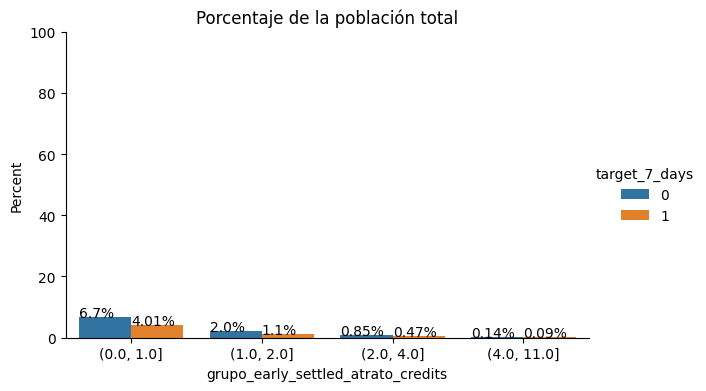

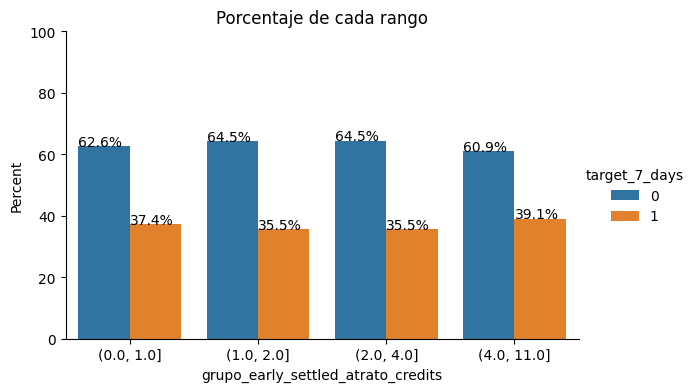

In [191]:
AnalisisBivariado(df_bivariados, 'early_settled_atrato_credits',[0, 1, 2, 4,df_bivariados['early_settled_atrato_credits'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [192]:
df_sin_nulos_b['early_settled_atrato_credits'].median()

1.0

In [193]:
df_sin_nulos_b['early_settled_atrato_credits'].fillna(1, inplace=True)

Correlación: -0.020223339064342125 
 Covarianza: -0.003802887966057169
Porcentaje total:  100.0


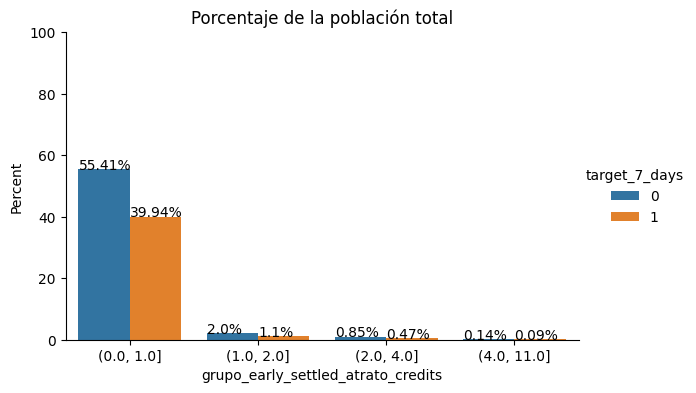

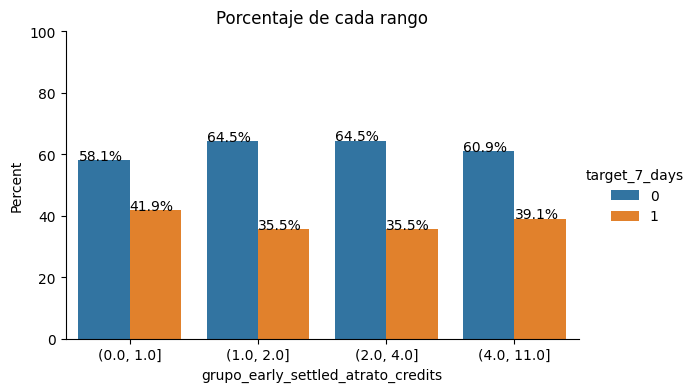

In [194]:
AnalisisBivariado(df_sin_nulos_b, 'early_settled_atrato_credits',[0, 1, 2, 4,df_sin_nulos_b['early_settled_atrato_credits'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [195]:
df_sin_nulos_c['early_settled_atrato_credits'].mean()

1.4633574629438124

In [196]:
df_sin_nulos_c['early_settled_atrato_credits'].fillna(1.46, inplace=True)

Correlación: -0.0028593027250474797 
 Covarianza: -0.0004833738763479351
Porcentaje total:  100.0


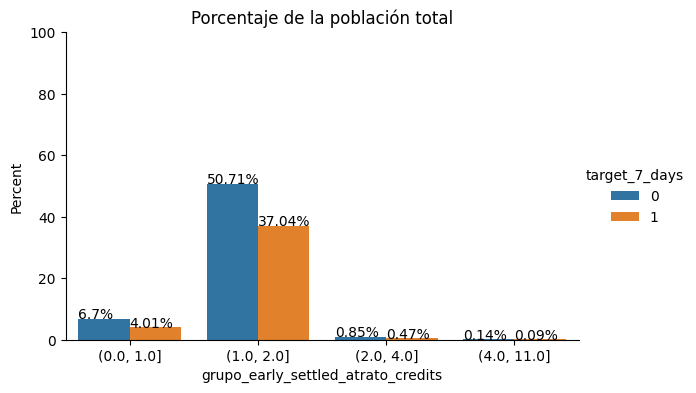

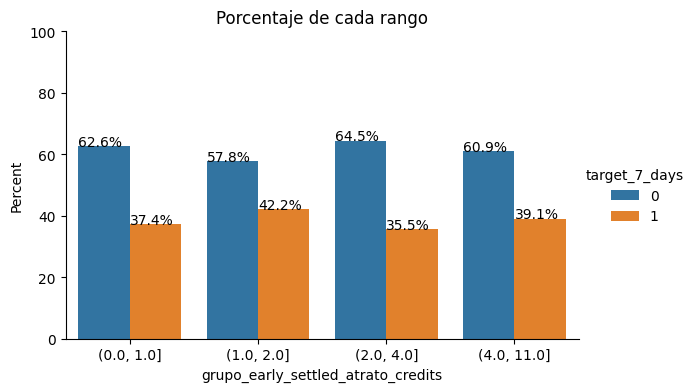

In [197]:
AnalisisBivariado(df_sin_nulos_c, 'early_settled_atrato_credits',[0, 1, 2, 4,df_sin_nulos_c['early_settled_atrato_credits'].max()], False)

<font face='Verdana' size=3>NULL --> 0 </font>

In [198]:
df_sin_nulos_a['early_settled_atrato_credits'].fillna(0, inplace=True)

Correlación: -0.035523025921349885 
 Covarianza: -0.011019222943685908
Porcentaje total:  15.362048696794146


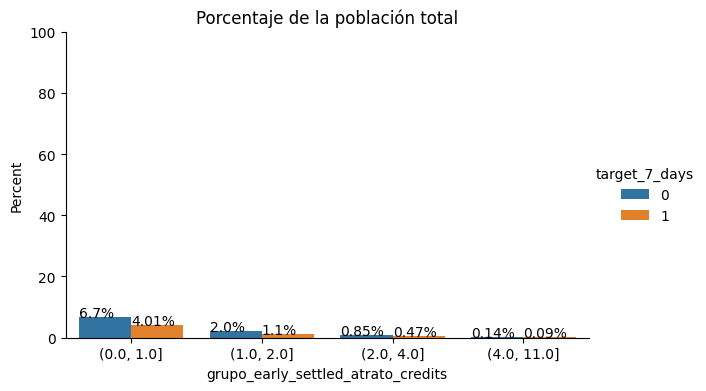

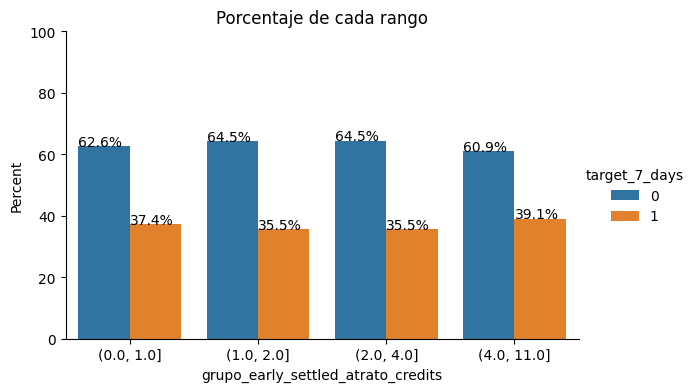

In [199]:
AnalisisBivariado(df_sin_nulos_a, 'early_settled_atrato_credits',[0, 1, 2, 4,df_sin_nulos_a['early_settled_atrato_credits'].max()], False)

<font face='Verdana' size=3>**ANÁLISIS DE CASOS**</font>

1.- <font face='Verdana' size=3>Casos nulos que **si** tienen créditos pasados: estos casos se pueden llenar con 0, indicando que no ha liquidado anticipadamente ninguno de sus créditos anteriores.</font>

2.- <font face='Verdana' size=3>Casos nulos que **no** tienen créditos pasados: estos casos se pueden llenar con -1, indicando que no es observable.</font>

In [200]:
# Llenar los nulos según las condiciones
df_sin_nulos['early_settled_atrato_credits'] = df_sin_nulos['early_settled_atrato_credits'].fillna(df_sin_nulos['num_atrato_credits'].apply(lambda x: -1 if x == 1 else 0))


In [201]:
df_sin_nulos['early_settled_atrato_credits'].describe()

count    94421.000000
mean        -0.335222
std          0.945651
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          0.000000
max         11.000000
Name: early_settled_atrato_credits, dtype: float64

Correlación: -0.07600841609426903 
 Covarianza: -0.03542833240968184
Porcentaje total:  100.0


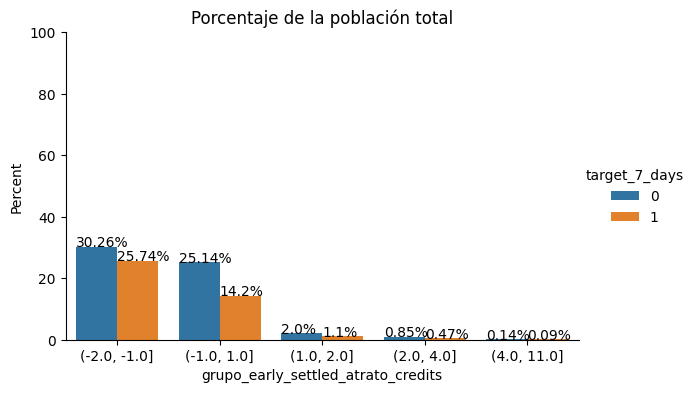

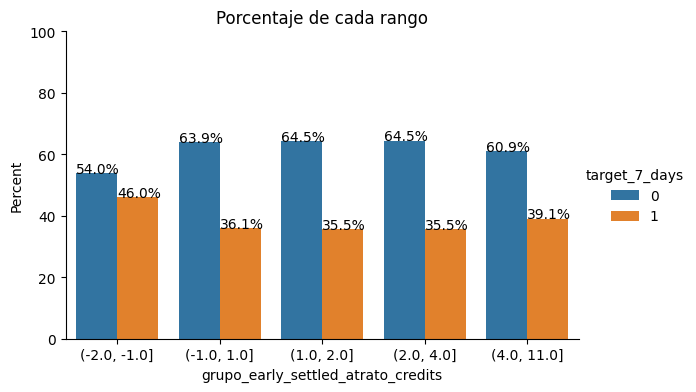

In [202]:
AnalisisBivariado(df_sin_nulos, 'early_settled_atrato_credits',[-2,-1,1, 2, 4,df_sin_nulos['early_settled_atrato_credits'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> para first, se llenan nulos con **-1** , para recurrentes se llenan nulos con  **0** </font>

## <font face='Monaco' color='#70b8db' size=4>monthly_payment_terms</font>

In [203]:
df['monthly_payment_terms'].describe()

count    94421.000000
mean        11.490293
std          5.386648
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         40.000000
Name: monthly_payment_terms, dtype: float64

In [204]:
df['monthly_payment_terms'].isnull().sum()/len(df)*100

0.0

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>NO NULOS: </font> variable no contiene nulos</font>

## <font face='Monaco' color='#70b8db' size=4>age</font>

In [205]:
df['age'].describe()

count    94421.000000
mean        36.516315
std         11.016182
min         18.000000
25%         28.000000
50%         34.000000
75%         43.000000
max         72.000000
Name: age, dtype: float64

In [206]:
df['age'].median()

34.0

In [207]:
df['age'].isnull().sum()/len(df)*100

0.0

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>NO NULOS: </font> variable no contiene nulos</font>

## <font face='Monaco' color='#70b8db' size=4>payments_before_first_overdue</font>

In [208]:
df['payments_before_first_overdue'].describe()

count    81605.000000
mean         9.396324
std         15.723144
min         -1.000000
25%          1.000000
50%          5.000000
75%         12.000000
max        507.000000
Name: payments_before_first_overdue, dtype: float64

In [209]:
len(df[df['payments_before_first_overdue']==0])/len(df)*100

7.361709789135891

In [210]:
df['payments_before_first_overdue'].isnull().sum()/len(df)*100

13.573251713072304

In [211]:
len(df[df['payments_before_first_overdue']<0])/len(df)*100

12.042871818769129

In [212]:
len(df[df['payments_before_first_overdue']==1])/len(df)*100

7.2462693680431265

In [213]:
IQR = df['payments_before_first_overdue'].describe()[6]-df['payments_before_first_overdue'].describe()[4]
rango = [df['payments_before_first_overdue'].describe()[4]-IQR*1.5, df['payments_before_first_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-15.5, 28.5]


Correlación: 0.014760459098588545 
 Covarianza: 0.11271957247386075
Porcentaje total:  86.4267482869277
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


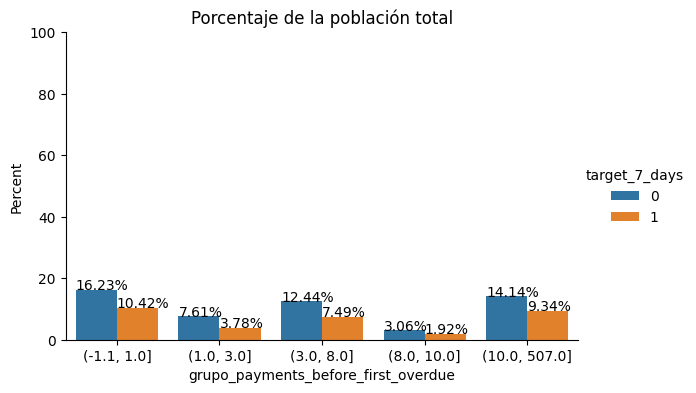

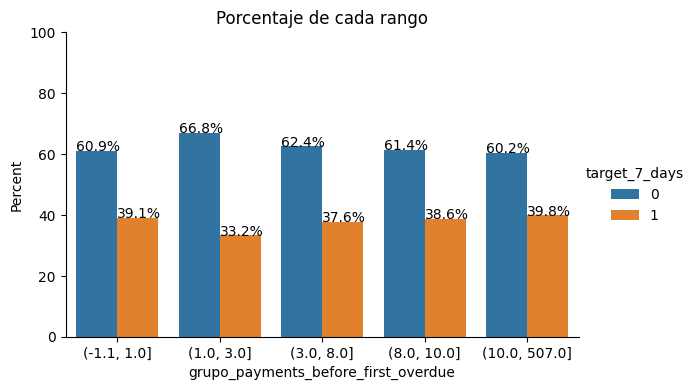

In [214]:
AnalisisBivariado(df_bivariados, 'payments_before_first_overdue',[-1.1, 1, 3, 8, 10, df_bivariados['payments_before_first_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [215]:
df_sin_nulos_b['payments_before_first_overdue'].median()

5.0

In [216]:
df_sin_nulos_b['payments_before_first_overdue'].fillna(4, inplace=True)

Correlación: -0.008930182560901924 
 Covarianza: -0.06485241949125448
Porcentaje total:  100.0


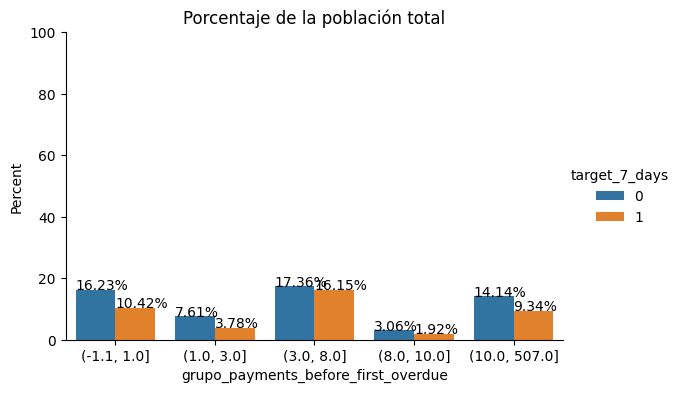

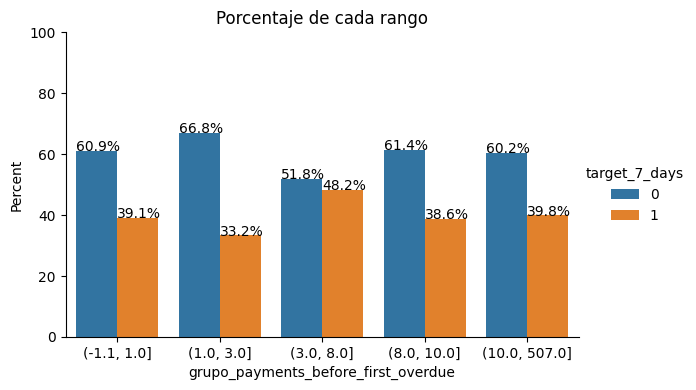

In [217]:
AnalisisBivariado(df_sin_nulos_b, 'payments_before_first_overdue',[-1.1, 1, 3, 8, 10, df_sin_nulos_b['payments_before_first_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [218]:
df_sin_nulos_c['payments_before_first_overdue'].mean()

9.396323754671895

In [219]:
df_sin_nulos_c['payments_before_first_overdue'].fillna(9, inplace=True)

Correlación: 0.011866853655798645 
 Covarianza: 0.08550190134056472
Porcentaje total:  100.0


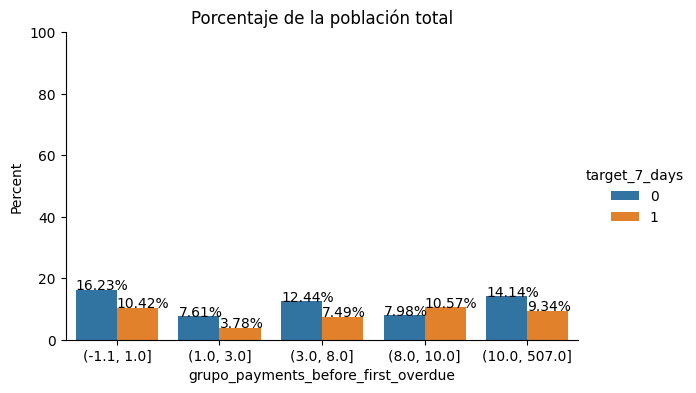

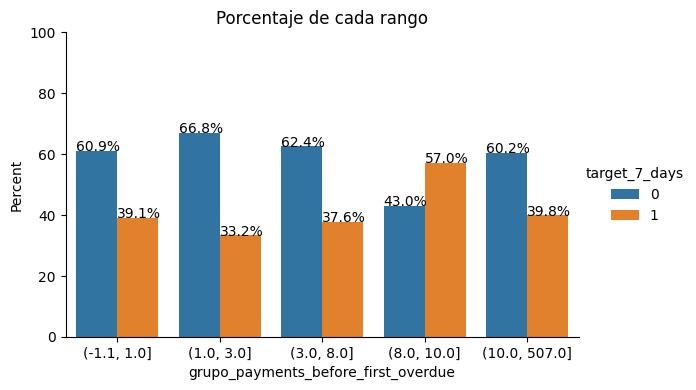

In [220]:
AnalisisBivariado(df_sin_nulos_c, 'payments_before_first_overdue',[-1.1, 1, 3, 8, 10, df_sin_nulos_c['payments_before_first_overdue'].max()], False)

<font face='Verdana' size=3>Otro valor: usamos 0 para mantener tendencia</font>

In [221]:
df_sin_nulos_a['payments_before_first_overdue'].fillna(0, inplace=True)

Correlación: -0.02509515530095017 
 Covarianza: -0.18513587615670943
Porcentaje total:  100.0


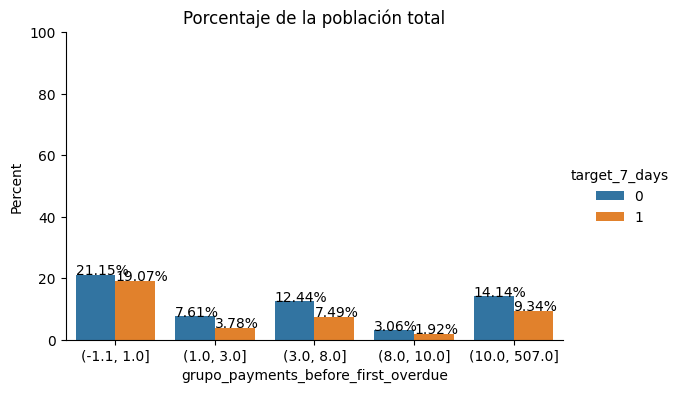

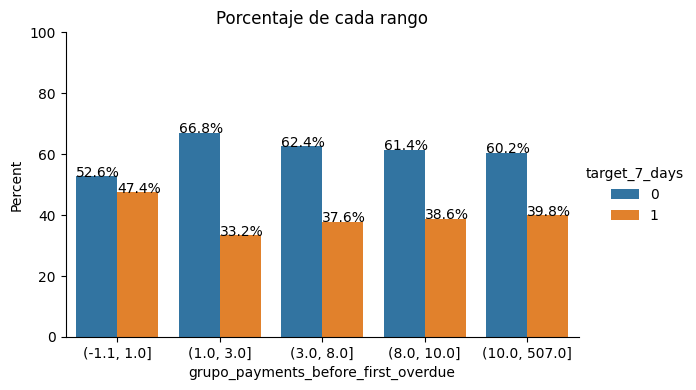

In [222]:
AnalisisBivariado(df_sin_nulos_a, 'payments_before_first_overdue',[-1.1, 1, 3, 8, 10, df_sin_nulos_a['payments_before_first_overdue'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Distribución y tendencia creciente se ve mejor con valor adaptado (0)</font>

## <font face='Monaco' color='#70b8db' size=4>payments_before_worst_overdue</font>

In [223]:
df['payments_before_worst_overdue'].describe()

count    81605.000000
mean        24.226971
std         41.102377
min         -1.000000
25%          2.000000
50%         11.000000
75%         29.000000
max       1300.000000
Name: payments_before_worst_overdue, dtype: float64

In [224]:
len(df[df['payments_before_worst_overdue']==0])/len(df)*100

3.6835026106480546

In [225]:
len(df[df['payments_before_worst_overdue']==1])/len(df)*100

3.352008557418371

In [226]:
df['payments_before_worst_overdue'].isnull().sum()/len(df)*100

13.573251713072304

In [227]:
IQR = df['payments_before_worst_overdue'].describe()[6]-df['payments_before_worst_overdue'].describe()[4]
rango = [df['payments_before_worst_overdue'].describe()[4]-IQR*1.5, df['payments_before_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-38.5, 69.5]


Correlación: 0.0006721156055607722 
 Covarianza: 0.013417481547533016
Porcentaje total:  86.42674828692769
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


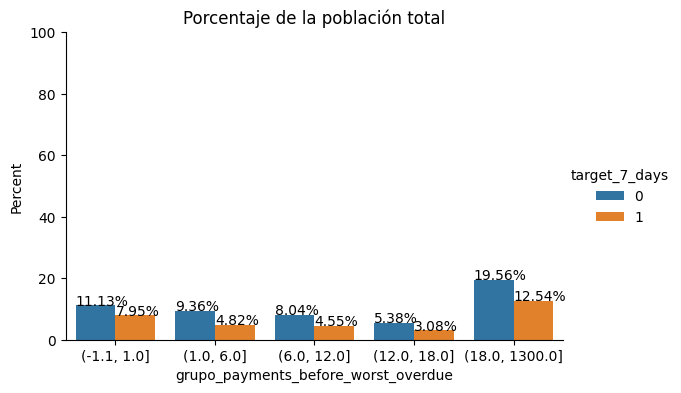

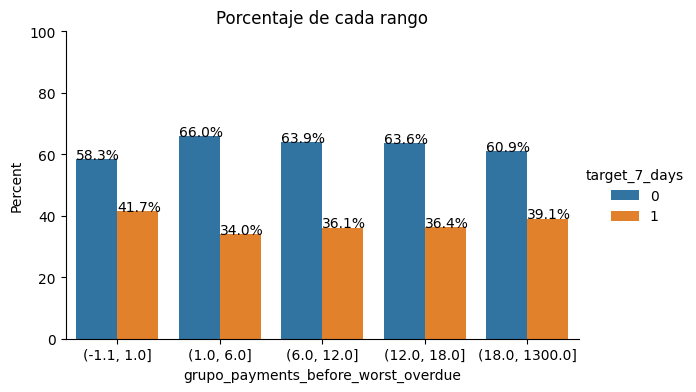

In [228]:
AnalisisBivariado(df_bivariados, 'payments_before_worst_overdue',[-1.1, 1, 6, 12, 18, df_bivariados['payments_before_worst_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [229]:
df_sin_nulos_b['payments_before_worst_overdue'].median()

11.0

In [230]:
df_sin_nulos_b['payments_before_worst_overdue'].fillna(11, inplace=True)

Correlación: 0.0006721156055607722 
 Covarianza: 0.013417481547533016
Porcentaje total:  86.42674828692769
Relación de target_7_days nulos:
	 1s: 36.243757802746565 (4645)
	 0s: 63.756242197253435 (8171)


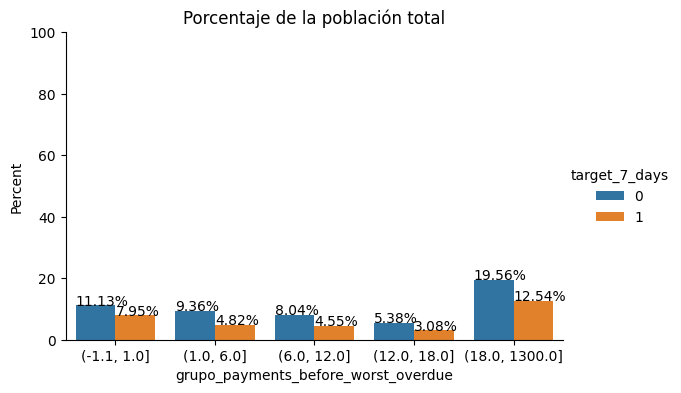

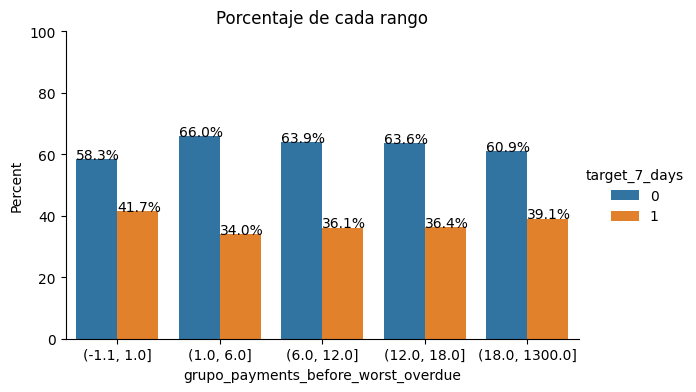

In [231]:
AnalisisBivariado(df_bivariados, 'payments_before_worst_overdue',[-1.1, 1, 6, 12, 18, df_bivariados['payments_before_worst_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [232]:
df_sin_nulos_c['payments_before_worst_overdue'].mean()

24.226971386557196

In [233]:
df_sin_nulos_c['payments_before_worst_overdue'].fillna(24.22, inplace=True)

Correlación: 0.0006045698663195451 
 Covarianza: 0.011386638097162399
Porcentaje total:  100.0


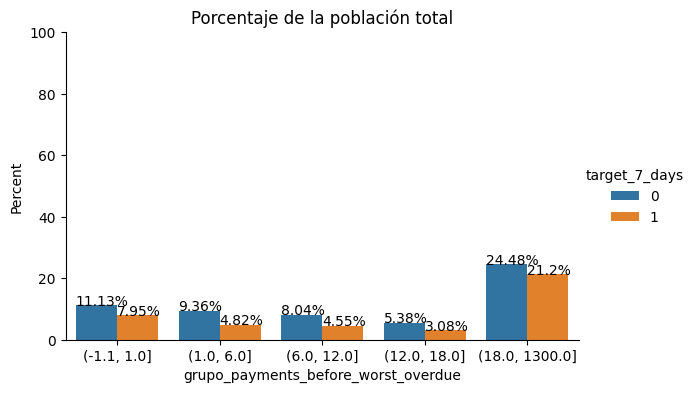

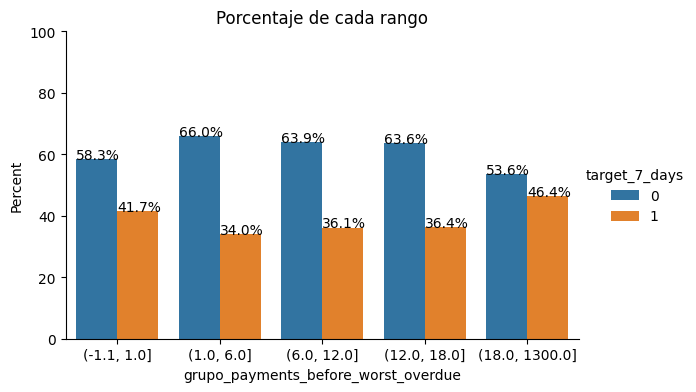

In [234]:
AnalisisBivariado(df_sin_nulos_c, 'payments_before_worst_overdue',[-1.1, 1, 6, 12, 18, df_sin_nulos_c['payments_before_worst_overdue'].max()], False)

<font face='Verdana' size=3>Otro valor: usamos 0 para mantener tendencia</font>

In [235]:
df_sin_nulos_a['payments_before_worst_overdue'].fillna(0, inplace=True)

Correlación: -0.03719816187002255 
 Covarianza: -0.7169296920121697
Porcentaje total:  100.0


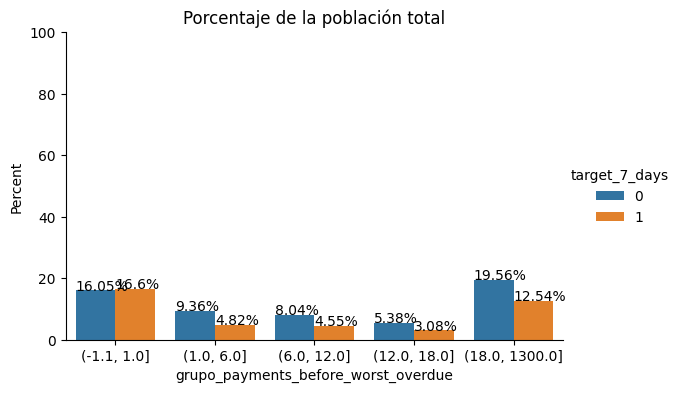

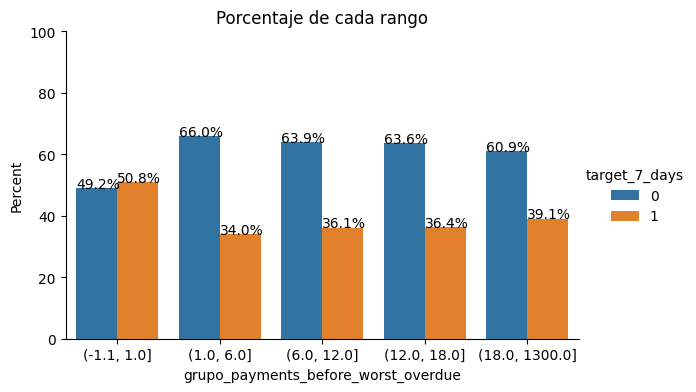

In [236]:
AnalisisBivariado(df_sin_nulos_a, 'payments_before_worst_overdue',[-1.1, 1, 6, 12, 18, df_sin_nulos_a['payments_before_worst_overdue'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Distribución y tendencia creciente se ve mejor con MEDIANA (11)</font>

## <font face='Monaco' color='#70b8db' size=4>days_of_worst_overdue</font>

In [237]:
df['days_of_worst_overdue'].describe()

count    69453.000000
mean        15.671504
std         15.423766
min          1.000000
25%          6.000000
50%         13.000000
75%         19.000000
max        315.000000
Name: days_of_worst_overdue, dtype: float64

In [238]:
df['days_of_worst_overdue'].isnull().sum()/len(df)*100

26.44327003526758

In [239]:
IQR = df['days_of_worst_overdue'].describe()[6]-df['days_of_worst_overdue'].describe()[4]
rango = [df['days_of_worst_overdue'].describe()[4]-IQR*1.5, df['days_of_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-13.5, 38.5]


Correlación: 0.12715024729094726 
 Covarianza: 0.945680733416827
Porcentaje total:  73.55672996473243
Relación de target_7_days nulos:
	 1s: 44.9855815443768 (11232)
	 0s: 55.01441845562319 (13736)


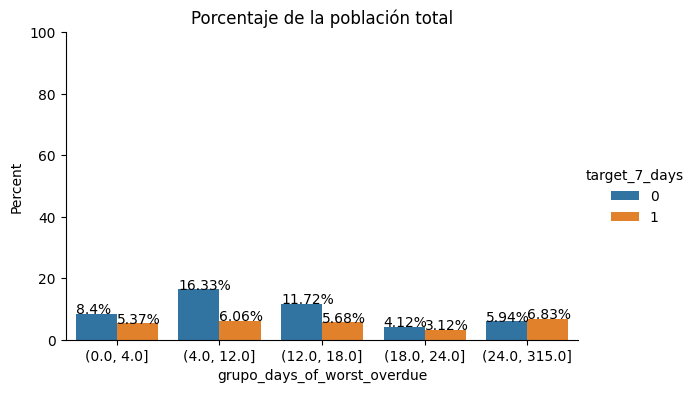

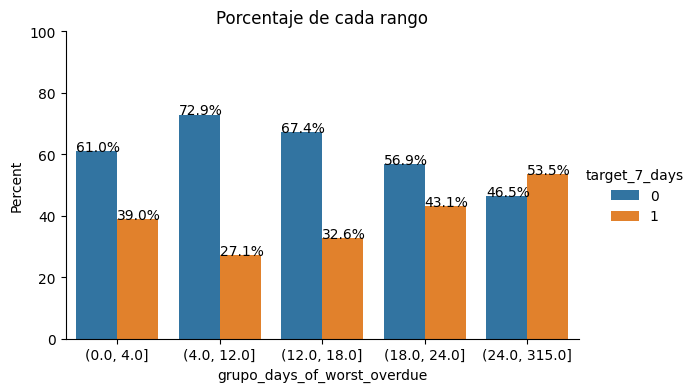

In [240]:
AnalisisBivariado(df_bivariados, 'days_of_worst_overdue',[0, 4, 12, 18, 24, df_bivariados['days_of_worst_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [241]:
df_sin_nulos_b['days_of_worst_overdue'].median()

13.0

In [242]:
df_sin_nulos_b['days_of_worst_overdue'].fillna(13, inplace=True)

Correlación: 0.09179033378450978 
 Covarianza: 0.6008582197314339
Porcentaje total:  100.0


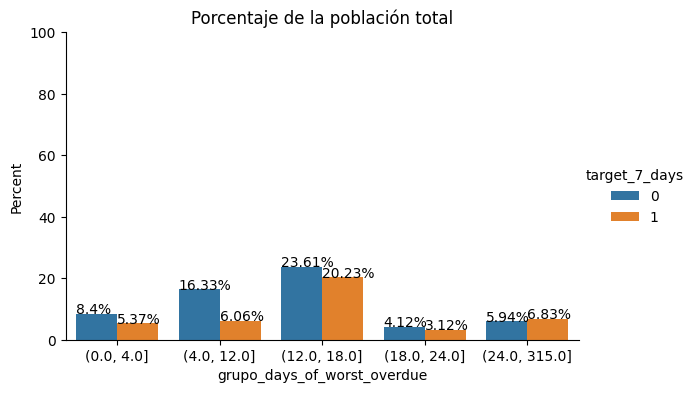

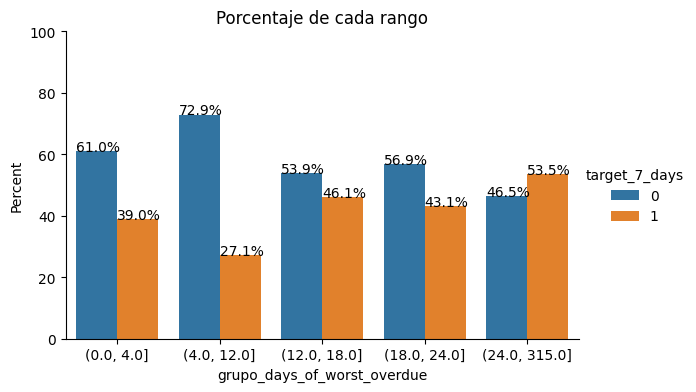

In [243]:
AnalisisBivariado(df_sin_nulos_b, 'days_of_worst_overdue',[0, 4, 12, 18, 24,df_sin_nulos_b['days_of_worst_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [244]:
df_sin_nulos_c['days_of_worst_overdue'].mean()

15.671504470649216

In [245]:
df_sin_nulos_c['days_of_worst_overdue'].fillna(15.67, inplace=True)

Correlación: 0.10667749738903902 
 Covarianza: 0.6955558154757894
Porcentaje total:  100.0


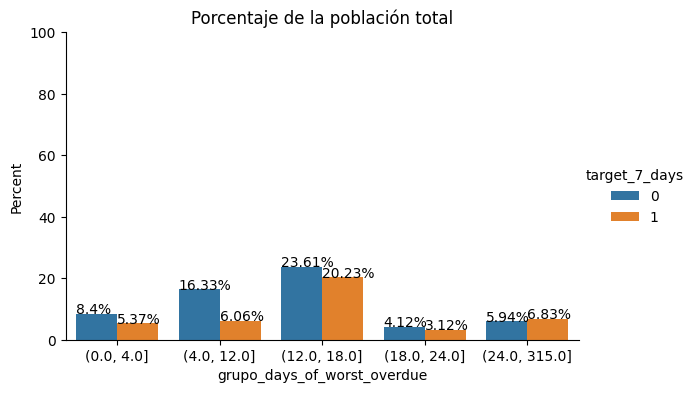

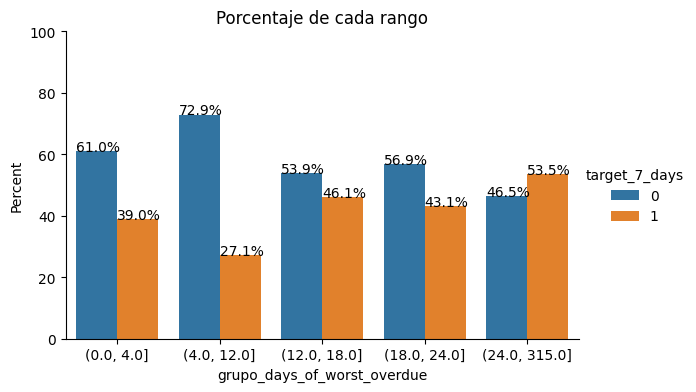

In [246]:
AnalisisBivariado(df_sin_nulos_c, 'days_of_worst_overdue',[0, 4, 12, 18, 24,df_sin_nulos_c['days_of_worst_overdue'].max()], False)

<font face='Verdana' size=3>NULL --> otro valor (5) </font>

In [247]:
df_sin_nulos_a['days_of_worst_overdue'].fillna(11, inplace=True)

Correlación: 0.08030627791627735 
 Covarianza: 0.5299236910839723
Porcentaje total:  99.99999999999999


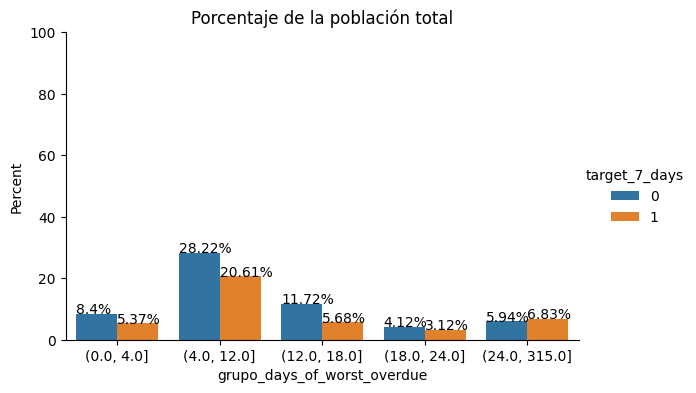

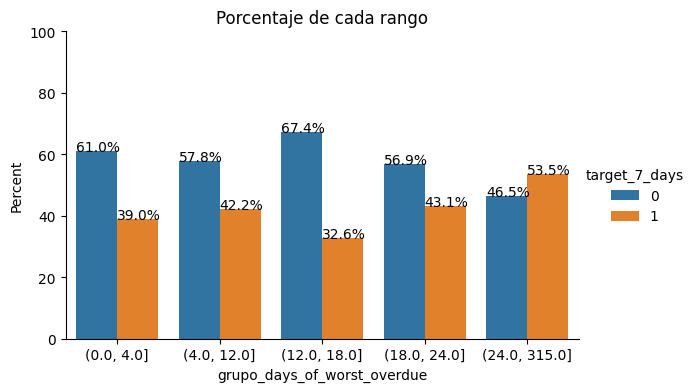

In [248]:
AnalisisBivariado(df_sin_nulos_a, 'days_of_worst_overdue',[0, 4, 12, 18, 24,df_sin_nulos_a['days_of_worst_overdue'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Distribución y tendencia creciente se ve mejor con MEDIANA (13)</font>

## <font face='Monaco' color='#70b8db' size=4>has_mortgage_or_large_loans</font>

In [249]:
df['has_mortgage_or_large_loans'].value_counts()

has_mortgage_or_large_loans
1.0    13455
Name: count, dtype: int64

In [250]:
df['has_mortgage_or_large_loans'].value_counts(normalize=True)

has_mortgage_or_large_loans
1.0    1.0
Name: proportion, dtype: float64

In [251]:
df['has_mortgage_or_large_loans'].isnull().sum()/len(df)*100

85.74999205685177

Correlación: nan 
 Covarianza: 0.0
Porcentaje total:  14
Relación de target_7_days nulos:
	 1s:57.71681940567645 (46731)
	 0s:42.28318059432355 (34235)


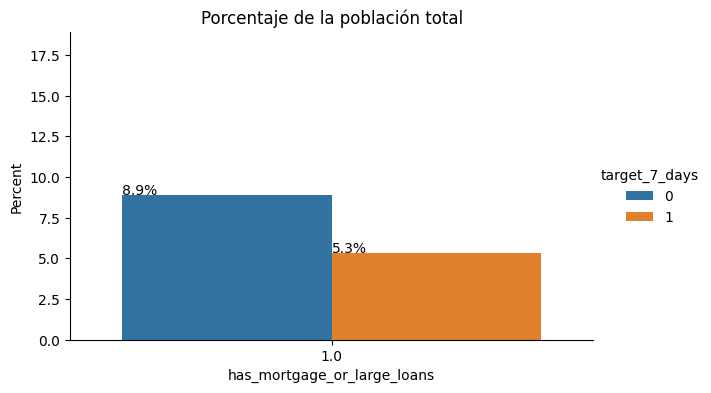

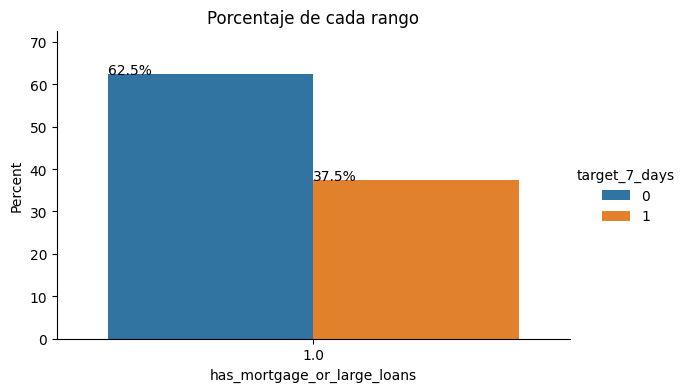

In [252]:
AnalisisBivariado(df_bivariados, 'has_mortgage_or_large_loans', None, True)

<font face='Verdana' size=3>NULL --> 0 </font>

In [253]:
df_sin_nulos['has_mortgage_or_large_loans'].fillna(0, inplace=True)

Correlación: -0.033902536653006875 
 Covarianza: -0.0058414066950652445
Porcentaje total:  100


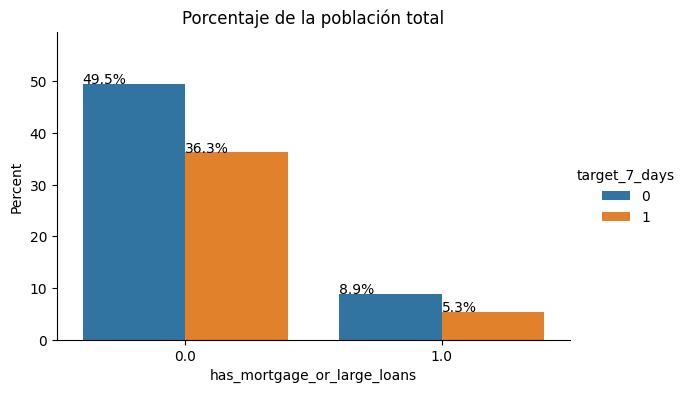

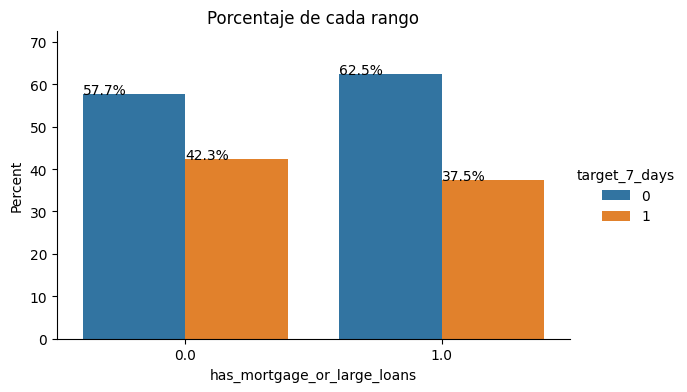

In [254]:
AnalisisBivariado(df_sin_nulos, 'has_mortgage_or_large_loans', None, True)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> 0</font>

## <font face='Monaco' color='#70b8db' size=4>current_debt</font>

In [255]:
df['current_debt'].describe()

count    81436.000000
mean         0.615995
std          0.252883
min          0.003000
25%          0.407000
50%          0.667000
75%          0.839000
max          1.000000
Name: current_debt, dtype: float64

In [256]:
df['current_debt'].isnull().sum()/len(df)*100

13.752237320087692

In [257]:
IQR = df['current_debt'].describe()[6]-df['current_debt'].describe()[4]
rango = [df['current_debt'].describe()[4]-IQR*1.5, df['current_debt'].describe()[6]+IQR*1.5]
print(rango)

[-0.24100000000000016, 1.487]


Correlación: 0.05417555950869443 
 Covarianza: 0.0066593717877688405
Porcentaje total:  86.24776267991231
Relación de target_7_days nulos:
	 1s: 37.589526376588374 (4881)
	 0s: 62.41047362341163 (8104)


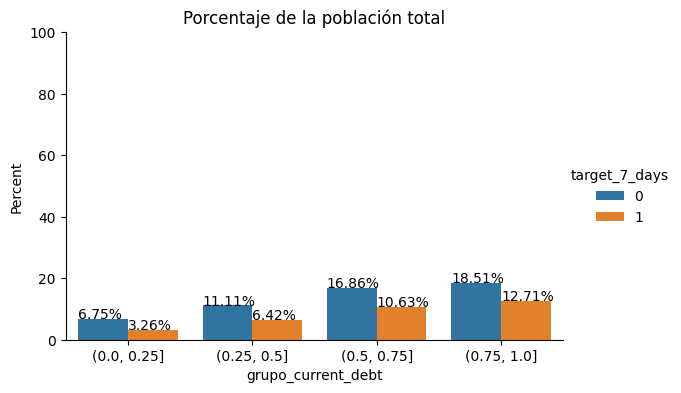

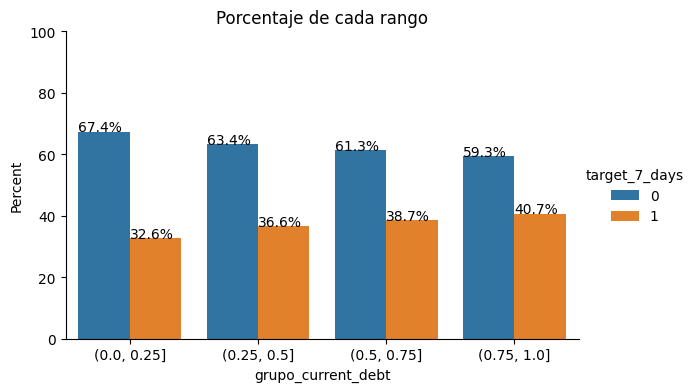

In [258]:
AnalisisBivariado(df_bivariados, 'current_debt',[0, 0.25, 0.5, 0.75, df_bivariados['current_debt'].max()], False)

<font face='Verdana' size=3>NULL --> median </font>

In [259]:
df_sin_nulos_b['current_debt'].median()

0.667

In [260]:
df_sin_nulos_b['current_debt'].fillna(0.667, inplace=True)

Correlación: 0.062052512337989 
 Covarianza: 0.007203147033718638
Porcentaje total:  100.0


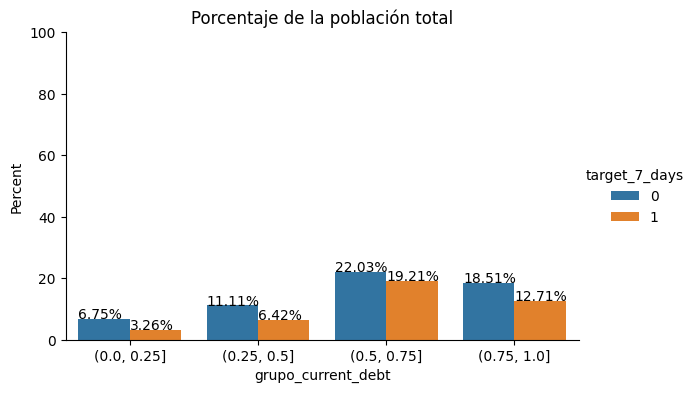

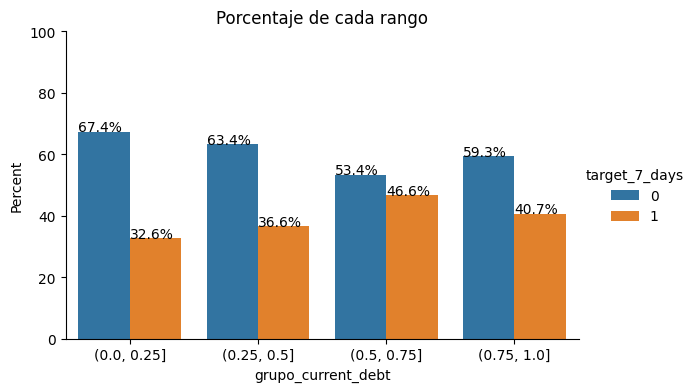

In [261]:
AnalisisBivariado(df_sin_nulos_b, 'current_debt',[0, 0.25, 0.5, 0.75, df_sin_nulos_b['current_debt'].max()], False)

<font face='Verdana' size=3>NULL --> mean </font>

In [262]:
df_sin_nulos_c['current_debt'].mean()

0.6159948057370206

In [263]:
df_sin_nulos_c['current_debt'].fillna(0.615, inplace=True)

Correlación: 0.04937084019598764 
 Covarianza: 0.005715081473123317
Porcentaje total:  100.0


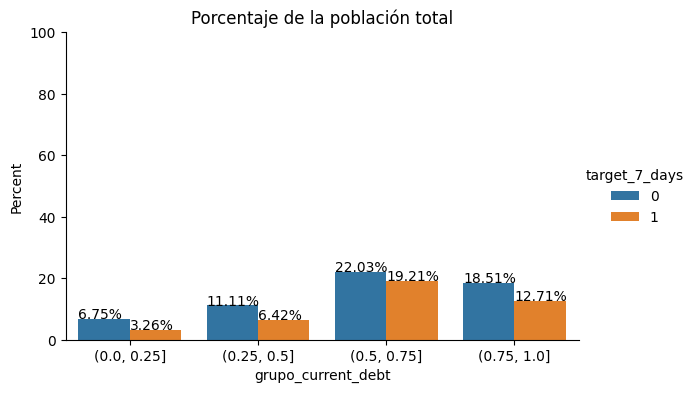

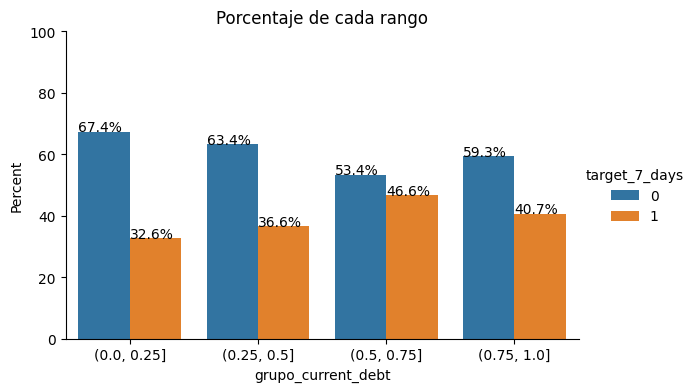

In [264]:
AnalisisBivariado(df_sin_nulos_c, 'current_debt',[0, 0.25, 0.5, 0.75, df_sin_nulos_c['current_debt'].max()], False)

<font face='Verdana' size=3>NULL --> otro valor (0.8) </font>

In [265]:
df_sin_nulos_a['current_debt'].fillna(0.8, inplace=True)

Correlación: 0.09182079928427608 
 Covarianza: 0.011009160871395146
Porcentaje total:  100.0


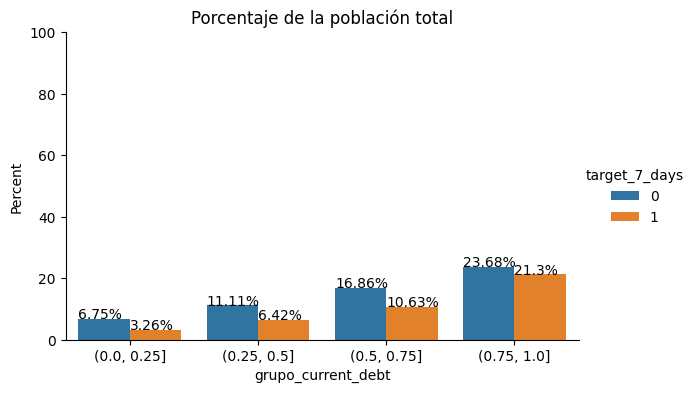

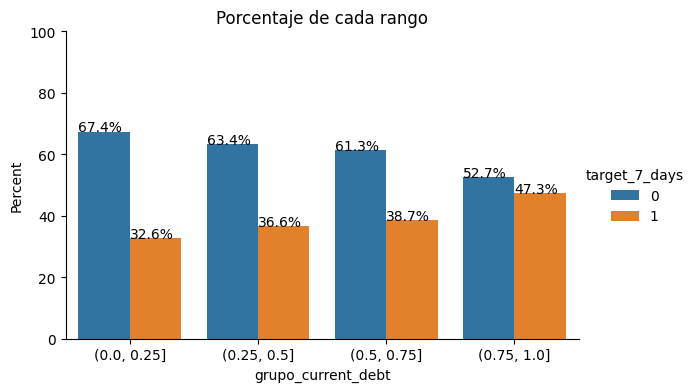

In [266]:
AnalisisBivariado(df_sin_nulos_a, 'current_debt',[0, 0.25, 0.5, 0.75, df_sin_nulos_c['current_debt'].max()], False)

<font face='Tahoma' size=3><font color='#669999' face='Tahoma' size=4>Llenado de nulos: </font> Distribución y tendencia creciente se ve mejor con Valor de 0.8</font>

marker

# monthly_payment_terms

In [ ]:
df['monthly_payment_terms'].describe()

In [ ]:
df['monthly_payment_terms'].unique().shape

In [ ]:
AnalisisBivariado(df_bivariados, 'monthly_payment_terms', [0,8,16,24,32,40], False)

# age

In [ ]:
df['age'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'age', [17, 27, 36, 45, 54], False)

# gender

In [ ]:
df['gender'].unique()

In [ ]:
label_encoder_gender = LabelEncoder()
df_bivariados['gender'] = label_encoder_gender.fit_transform(df_bivariados['gender'])
classes = label_encoder_gender.classes_
print('Clases:', classes)
class_mapping = {cls: idx for idx, cls in enumerate(classes)}
print('Mapeo de clase a código:', class_mapping)

In [ ]:
AnalisisBivariado(df_bivariados, 'gender', None, True)

# granted_credit_amount

In [ ]:
df['granted_credit_amount'].describe()

In [ ]:
IQR = df['granted_credit_amount'].describe()[6]-df['granted_credit_amount'].describe()[4]
rango = [df['granted_credit_amount'].describe()[4]-IQR*1.5, df['granted_credit_amount'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'granted_credit_amount', [0, 7500, 15000, 22500, 30000, 37500, 205000], False)

# num_expected_payments_monthly

In [ ]:
df['num_expected_payments_monthly'].describe()

Preguntar a Carlos si los mensualizó

In [ ]:
df['num_expected_payments_monthly'].unique().shape

In [ ]:
IQR = df['num_expected_payments_monthly'].describe()[6]-df['num_expected_payments_monthly'].describe()[4]
rango = [df['num_expected_payments_monthly'].describe()[4]-IQR*1.5, df['num_expected_payments_monthly'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'num_expected_payments_monthly', [0,3,6,9,12,15,18,56], False)

# risk_profile_v1

Deberíamos dejarla? dado que eventualmente queremos eliminar el PR1

In [ ]:
df['risk_profile_v1'].value_counts(normalize=True)*100

In [ ]:
#Como tiene datos ' ' que deberían ser nulos, los reemplazamos
df['risk_profile_v1'] = df['risk_profile_v1'].replace(' ', np.nan)
df[df['risk_profile_v1'].isna()].shape[0]/len(df)*100

In [ ]:
# Eliminar los registros con PR1 nulos ya que no representan un porcentaje alto.
df_sin_nulos = df_sin_nulos[~df_sin_nulos['risk_profile_v1'].isna()]
df = df[~df['risk_profile_v1'].isna()]
df_bivariados = df_bivariados[~df_bivariados['risk_profile_v1'].isna()]

In [ ]:
# Se codifican los valores del risk profile
ordinal_map_PR1 = {'A1': 1,'A2': 2,'A3': 3,'B1': 4, 'B2':5, 'B3':6, 'C1':7, 'C2':8, 'C3': 9}
df_bivariados['risk_profile_v1'] = df_bivariados['risk_profile_v1'].map(ordinal_map_PR1)

In [ ]:
AnalisisBivariado(df_bivariados, 'risk_profile_v1', None, True)

Agrupar por PR1, tienen comportamiento parecido.

# num_atrato_credits

In [ ]:
df['num_atrato_credits'].describe()

In [ ]:
df[df['num_atrato_credits']==1]

In [ ]:
IQR = df['num_atrato_credits'].describe()[6]-df['num_atrato_credits'].describe()[4]
rango = [df['num_atrato_credits'].describe()[4]-IQR*1.5, df['num_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'num_atrato_credits', [0,2,4,17], False)

Por qué hay nulos en esta variable?

In [ ]:
df[['idobservation','id_solicitud','credito_created_at_utc', 'payment_history', target]][df['num_atrato_credits'].isna()]

# historical_overdue_atrato_credits

In [ ]:
df['historical_overdue_atrato_credits'].describe()

In [ ]:
df['diff'] = df['num_atrato_credits']-df['historical_overdue_atrato_credits']
df['diff'].describe() 

Se elimina la variable historical_overdue_atrato_credits

In [ ]:
del df['historical_overdue_atrato_credits']
del df_sin_nulos['historical_overdue_atrato_credits']
del df_bivariados['historical_overdue_atrato_credits']

# owed_amount_cc

In [ ]:
df['owed_amount_cc'].describe()

In [ ]:
IQR = df['owed_amount_cc'].describe()[6]-df['owed_amount_cc'].describe()[4]
rango = [df['owed_amount_cc'].describe()[4]-IQR*1.5, df['owed_amount_cc'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'owed_amount_cc', [-1, 0, 3000, 6000, 9000, df['owed_amount_cc'].max()], False)

La distribución de los valores nulos es parecida a la de 3000 a 6000 por lo que los valores nulos se llenaran con estos datos.

In [ ]:
df_sin_nulos['owed_amount_cc'].fillna(4500, inplace=True)
AnalisisBivariado(df_sin_nulos, 'owed_amount_cc', [-1, 0, 3000, 6000, 9000, df['owed_amount_cc'].max()], False)

# risk_profile_v2

In [ ]:
df['risk_profile_v2'].value_counts(normalize=True)*100

In [ ]:
ordinal_map_PR2 = {'A1': 1,'A2': 2,'B1': 3,'B2': 4, 'C1':5, 'C2':6, 'D1':7}
df_bivariados['risk_profile_v2'] = df_bivariados['risk_profile_v2'].map(ordinal_map_PR2)

In [ ]:
AnalisisBivariado(df_bivariados, 'risk_profile_v2', None, True)

Para no beneficiar ni perjudicar a los clientes que no tengan PR2, se llenará el nulo con un 4 o un 2 en caso de decidir agrupar.

In [ ]:
df_sin_nulos['risk_profile_v2'].fillna(3, inplace=True)
ordinal_map_PR2 = {'A1': 1,'A2': 2,'B1': 3,'B2': 4, 'C1':5, 'C2':6, 'D1':7}
df_sin_nulos['risk_profile_v2'] = df_sin_nulos['risk_profile_v2'].map(ordinal_map_PR2)

In [ ]:
AnalisisBivariado(df_sin_nulos, 'risk_profile_v2', None, True)

# average_current_credit_delay

In [ ]:
df['average_current_credit_delay'].describe()

In [ ]:
IQR = df['average_current_credit_delay'].describe()[6]-df['average_current_credit_delay'].describe()[4]
rango = [df['average_current_credit_delay'].describe()[4]-IQR*1.5, df['average_current_credit_delay'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
df[df['average_current_credit_delay']<-5].shape[0]/len(df)*100

In [ ]:
df[df['average_current_credit_delay']>9].shape[0]/len(df)*100

De acuerdo con los datos hay pocos datos por debajo de -5, estos se consideran outliers según la definición d rango, sin embargo es de un crédito es decir si es un valor factible.

In [ ]:
df[df['average_current_credit_delay']<-5]

Como se observa estos casos son en su mayoría de personas que nunca se atrasan en su mayoría.

In [ ]:
AnalisisBivariado(df_bivariados, 'average_current_credit_delay', [-138, -5, 0, 3, 6, 9, 254], False)

Como no se muestra una clara tendencia se llenará con el valor de la mediana que es donde se concentra la mayoría de la población.

In [ ]:
median_average_current_credit_delay = df['average_current_credit_delay'].median()

In [ ]:
df_sin_nulos['average_current_credit_delay'].fillna(median_average_current_credit_delay, inplace=True)
AnalisisBivariado(df_sin_nulos, 'average_current_credit_delay', [-138, -5, 0, 3, 6, 9, 254], False)

# num_bucket_3

In [ ]:
df['num_bucket_3'].describe()

In [ ]:
df[df['num_bucket_3']>0]['num_bucket_3'].describe()

Si la correlación es muy baja se puede en este caso binarizar el num_bucket_3

In [ ]:
AnalisisBivariado(df_bivariados,'num_bucket_3',[-1,0,2,20], False)

De acuerdo con la distribución y el comportamiento general de la población, se llenaran los nulos con 0.

In [ ]:
df_sin_nulos['num_bucket_3'].fillna(0, inplace=True)
AnalisisBivariado(df_sin_nulos,'num_bucket_3',[-1,0,2,20], False)

# num_bucket_2

In [ ]:
df['num_bucket_2'].describe()

In [ ]:
df[df['num_bucket_2']>1]['num_bucket_2'].describe()

In [ ]:
AnalisisBivariado(df_bivariados,'num_bucket_2',[-1,0,2,4,20], False)

De acuerdo con la distribución y el comportamiento general de la población, se llenaran los nulos con 0.

In [ ]:
df_sin_nulos['num_bucket_2'].fillna(0,inplace=True)
AnalisisBivariado(df_sin_nulos,'num_bucket_2',[-1,0,2,4,20], False)

# num_bucket_1

In [ ]:
df['num_bucket_1'].describe()

In [ ]:
df[df['num_bucket_2']>2]['num_bucket_2'].describe()

In [ ]:
AnalisisBivariado(df_bivariados,'num_bucket_1',[-1,0,2,4,20], False)

De acuerdo con el comportamiento de los nulos, el comportamiento es parecido al del último bucket, se tomará la media de ese bucket para llenar los nulos.

In [ ]:
df_sin_nulos['num_bucket_1'].fillna(5,inplace=True)
AnalisisBivariado(df_sin_nulos,'num_bucket_1',[-1,0,2,20], False)

# sum_credits_was_late

In [ ]:
# Esta variable se descarta ya que es la misma que historical overdue credits.
del df['sum_credits_was_late']
del df_sin_nulos['sum_credits_was_late']
del df_bivariados['sum_credits_was_late']

# num_roll_down

In [ ]:
df['num_roll_down'].describe()

In [ ]:
df[df['num_roll_down']>1]['num_roll_down'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'num_roll_down', [-1, 0, 2, 4, 16], False)

Para no romper tendencia y no beneficiar a los nulos, el número de roll downs se llenará con 0's

In [ ]:
df_sin_nulos['num_roll_down'].fillna(0,inplace=True)
AnalisisBivariado(df_sin_nulos, 'num_roll_down', [-1, 0, 2, 4, 16], False)

# num_roll_up

In [ ]:
df['num_roll_up'].describe()

In [ ]:
df[df['num_roll_up']>1]['num_roll_down'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'num_roll_up', [-1, 0, 1, 2, 16], False)

No se ve sensibilidad por lo que se descarta

In [ ]:
del df['num_roll_up']
del df_sin_nulos['num_roll_up']
del df_bivariados['num_roll_up']

# avg_period_between_overdue

In [ ]:
df['avg_period_between_overdue'].describe()

In [ ]:
IQR = df['avg_period_between_overdue'].describe()[6]-df['avg_period_between_overdue'].describe()[4]
rango = [df['avg_period_between_overdue'].describe()[4]-IQR*1.5, df['avg_period_between_overdue'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
df[df['average_current_credit_delay']>10].shape[0]/len(df)*100

In [ ]:
AnalisisBivariado(df_bivariados, 'average_current_credit_delay', [-1, 0.5, 1, 3, 5, 7, 10], False)

Se llenará con la mediana que es el comportamiento más observado en la base. 

In [ ]:
df_sin_nulos['average_current_credit_delay'].fillna(0.16,inplace=True)

In [ ]:
AnalisisBivariado(df_sin_nulos, 'average_current_credit_delay', [-1, 1, 3, 5, 7, 10], False)

# current_credit_delay_trend

In [ ]:
df['current_credit_delay_trend'].describe()

In [ ]:
IQR = df['current_credit_delay_trend'].describe()[6]-df['current_credit_delay_trend'].describe()[4]
rango = [df['current_credit_delay_trend'].describe()[4]-IQR*1.5, df['current_credit_delay_trend'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
df[df['current_credit_delay_trend']<-0.7].shape[0]/len(df)*100

In [ ]:
df[df['current_credit_delay_trend']>1.5].shape[0]/len(df)*100

In [ ]:
AnalisisBivariado(df_bivariados, 'current_credit_delay_trend', [-61, -1, -0.5, 0, 0.5, 1, 1.5, 135], False)

In [ ]:
# Se llena con la mediana
df_sin_nulos['current_credit_delay_trend'].fillna(0.53,inplace=True)
AnalisisBivariado(df_sin_nulos, 'current_credit_delay_trend', [-61, -1, -0.5, 0, 0.5, 1, 1.5, 135], False)

# max_overdue_amount_to_monthly_payment_ratio

In [ ]:
df['max_overdue_amount_to_monthly_payment_ratio'].describe()

In [ ]:
IQR = df['max_overdue_amount_to_monthly_payment_ratio'].describe()[6]-df['max_overdue_amount_to_monthly_payment_ratio'].describe()[4]
rango = [df['max_overdue_amount_to_monthly_payment_ratio'].describe()[4]-IQR*1.5, df['max_overdue_amount_to_monthly_payment_ratio'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
df[df['max_overdue_amount_to_monthly_payment_ratio']>1.5].shape[0]/len(df)*100

In [ ]:
df[df['max_overdue_amount_to_monthly_payment_ratio']<0.76].shape[0]/len(df)*100

In [ ]:
AnalisisBivariado(df_bivariados, 'max_overdue_amount_to_monthly_payment_ratio', [0, 0.76, 1, 1.25, 1.5, 7], False)

In [ ]:
# Se llena con la media o mediana, coinciden al ser una distribución normal 
df_sin_nulos['max_overdue_amount_to_monthly_payment_ratio'].fillna(1.05,inplace=True)
AnalisisBivariado(df_sin_nulos, 'max_overdue_amount_to_monthly_payment_ratio', [0, 0.76, 1, 1.25, 1.5, 7], False)

# payments_before_worst_overdue

In [ ]:
df['payments_before_worst_overdue'].describe()

In [ ]:
IQR = df['payments_before_worst_overdue'].describe()[6]-df['payments_before_worst_overdue'].describe()[4]
rango = [df['payments_before_worst_overdue'].describe()[4]-IQR*1.5, df['payments_before_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'payments_before_worst_overdue', [-1, 15, 30, 45, 60, 75, 1160], False)

In [ ]:
df[df['payments_before_worst_overdue'].isna()][['payment_history']]

In [ ]:
hist = [25,28,26,30,24,25,25,27,27,22]
positive_num= [num for num in hist if num > 0]
positive_num.index(max(positive_num))

In [ ]:
def payments_before_worst_overdue(hist):
    if type(hist) == int or type(hist) == float:
        hist = str(hist)
    
    atrasos = list(reversed([int(elemento) for elemento in hist.split(',')]))
    positive_num = [num for num in atrasos if num > 0]
    if len(positive_num) == 0:
        pay_before = -1
    else:
        pay_before = positive_num.index(max(positive_num))
    return pay_before

In [ ]:
payments_before_worst_overdue('25,28,26,30,24,25,25,27,27,22')

In [ ]:
df.loc[(df['payments_before_worst_overdue'].isna())&(~df['payment_history'].isna()), 'payments_before_worst_overdue']  = df.loc[(df['payments_before_worst_overdue'].isna())&(~df['payment_history'].isna())].apply(lambda row: payments_before_worst_overdue(row['payment_history']), axis=1)
df_bivariados.loc[(df_bivariados['payments_before_worst_overdue'].isna())&(~df_bivariados['payment_history'].isna()), 'payments_before_worst_overdue']  = df_bivariados.loc[(df_bivariados['payments_before_worst_overdue'].isna())&(~df_bivariados['payment_history'].isna())].apply(lambda row: payments_before_worst_overdue(row['payment_history']), axis=1)

In [ ]:
df[df['payments_before_worst_overdue'].isna()][['payment_history']]

In [ ]:
df['payments_before_worst_overdue'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'payments_before_worst_overdue',[-2, 15, 30, 45, 60, 75, 1160], False)

In [ ]:
#Se llenará con la mediana que es 7
df_sin_nulos['payments_before_worst_overdue'].fillna(7, inplace=True)
AnalisisBivariado(df_sin_nulos, 'payments_before_worst_overdue', [-2, 15, 30, 45, 60, 75, 1160], False)

# payments_before_first_overdue

In [ ]:
df['payments_before_first_overdue'].describe()

In [ ]:
IQR = df['payments_before_first_overdue'].describe()[6]-df['payments_before_first_overdue'].describe()[4]
rango = [df['payments_before_first_overdue'].describe()[4]-IQR*1.5, df['payments_before_first_overdue'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'payments_before_first_overdue', [-1, 6, 12,18, 24, 30, 267], False)

In [ ]:
df[df['payments_before_first_overdue'].isna()][['payment_history']]

In [ ]:
hist = '25,28,26,30,24,25,25,27,27,22'
hist2 ='-2,3,4,-1'

In [ ]:
def payments_before_first_overdue(hist):
    if type(hist) == int or type(hist) == float:
        hist = str(hist)
    
    atrasos = list(reversed([int(elemento) for elemento in hist.split(',')]))
    indices_positivos = [i for i, num in enumerate(atrasos) if num > 0]
    if len(indices_positivos)==0:
        idx = -1
    else:
        idx = indices_positivos[0]
    return idx

In [ ]:
payments_before_first_overdue(hist2)

In [ ]:
# LLenado de nulos si hay payment history.
df.loc[(df['payments_before_first_overdue'].isna())&(~df['payment_history'].isna()), 'payments_before_first_overdue']  = df.loc[(df['payments_before_first_overdue'].isna())&(~df['payment_history'].isna())].apply(lambda row: payments_before_first_overdue(row['payment_history']), axis=1)
df_bivariados.loc[(df_bivariados['payments_before_first_overdue'].isna())&(~df_bivariados['payment_history'].isna()), 'payments_before_first_overdue']  = df_bivariados.loc[(df_bivariados['payments_before_first_overdue'].isna())&(~df_bivariados['payment_history'].isna())].apply(lambda row: payments_before_first_overdue(row['payment_history']), axis=1)

In [ ]:
df['payments_before_first_overdue'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'payments_before_first_overdue', [-2, 6, 12,18, 24, 30, 267], False)

In [ ]:
df_sin_nulos['payments_before_first_overdue'].fillna(3, inplace=True)  # mediana
AnalisisBivariado(df_sin_nulos, 'payments_before_first_overdue', [-2, 6, 12,18, 24, 30, 267], False)

# days_of_worst_overdue

In [ ]:
df['days_of_worst_overdue'].describe()

In [ ]:
IQR = df['days_of_worst_overdue'].describe()[6]-df['days_of_worst_overdue'].describe()[4]
rango = [df['days_of_worst_overdue'].describe()[4]-IQR*1.5, df['days_of_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
df[df['days_of_worst_overdue']>44].shape[0]/len(df)*100

In [ ]:
AnalisisBivariado(df_bivariados, 'days_of_worst_overdue', [0, 11, 22, 33, 44, 473], False)

Para no romper la tendencia, se llena con el punto medio del bucket de 22 a 33,   27

In [ ]:
df_sin_nulos['days_of_worst_overdue'].fillna(27, inplace=True)
AnalisisBivariado(df_sin_nulos, 'days_of_worst_overdue', [0, 11, 22, 33, 44, 473], False)

# ratio_overdue_payments

In [ ]:
df['ratio_overdue_payments'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [0,0.2,0.4,0.6,0.8,1], False)

Los nulos se deben llenar de acuerdo al histórico de pagos, en caso de ser nulo, se decidirá con la distribución.

In [ ]:
df[df['ratio_overdue_payments'].isna()][['payment_history', 'monthly_payment_terms']]

In [ ]:
def ratio_overdue_payments(hist, monthly_payment):
    if type(hist) == int or type(hist) == float:
        hist = str(hist)
    
    atrasos = list(reversed([int(elemento) for elemento in hist.split(',')]))
    indices_positivos = [i for i, num in enumerate(atrasos) if num > 0]
    return len(indices_positivos)/monthly_payment

In [ ]:
ratio_overdue_payments('25,28,26,30,24,25,25,27,27,22',12)

In [ ]:
# LLenado de nulos si hay payment history.
df.loc[(df['ratio_overdue_payments'].isna())&(~df['payment_history'].isna()), 'ratio_overdue_payments']  = df.loc[(df['ratio_overdue_payments'].isna())&(~df['payment_history'].isna())].apply(lambda row: ratio_overdue_payments(row['payment_history'], row['monthly_payment_terms']), axis=1)
df_bivariados.loc[(df_bivariados['ratio_overdue_payments'].isna())&(~df_bivariados['payment_history'].isna()), 'ratio_overdue_payments']  = df_bivariados.loc[(df_bivariados['ratio_overdue_payments'].isna())&(~df_bivariados['payment_history'].isna())].apply(lambda row: ratio_overdue_payments(row['payment_history'], row['monthly_payment_terms']), axis=1)

In [ ]:
df[df['ratio_overdue_payments'].isna()][['payment_history']]

In [ ]:
df['ratio_overdue_payments'].describe()

In [ ]:
AnalisisBivariado(df_bivariados, 'ratio_overdue_payments', [-1,0,0.2,0.4,0.6,0.8,1,2], False)

In [ ]:
#Los nulos llenamos con un valor cercano para no eliminar la tendencia.
df_sin_nulos['ratio_overdue_payments'].fillna(0.9, inplace=True)
AnalisisBivariado(df_sin_nulos, 'ratio_overdue_payments', [0,0.2,0.4,0.6,0.8,1,2], False)

# dashboard_inquiries

In [ ]:
df['dashboard_inquiries'].describe()

In [ ]:
IQR = df['dashboard_inquiries'].describe()[6]-df['dashboard_inquiries'].describe()[4]
rango = [df['dashboard_inquiries'].describe()[4]-IQR*1.5, df['dashboard_inquiries'].describe()[6]+IQR*1.5]
print(rango)

In [ ]:
AnalisisBivariado(df_bivariados, 'dashboard_inquiries', [0,20,40,60,80,100,120,1299], False)

En este caso los nulos se llenarán con 0's

In [ ]:
df_sin_nulos['dashboard_inquiries'].fillna(0, inplace=True)

In [ ]:
AnalisisBivariado(df_sin_nulos, 'dashboard_inquiries', [-1,20,40,60,80,100,120,1299], False)

# has_mortgage_or_large_loans

In [ ]:
df['has_mortgage_or_large_loans'].describe()

In [ ]:
df['has_mortgage_or_large_loans'].isnull().sum() /len(df)*100

In [ ]:
AnalisisBivariado(df, 'has_mortgage_or_large_loans',0, True)

con nulls as 0

In [ ]:
mortgage_no_nulls = df.copy()

In [ ]:
mortgage_no_nulls['has_mortgage_or_large_loans'].fillna(0, inplace = True)

In [ ]:
AnalisisBivariado(mortgage_no_nulls, 'has_mortgage_or_large_loans',0, True)

# has_mortgage_overdue

In [ ]:
df['has_mortgage_overdue'].describe()

In [ ]:
df['has_mortgage_overdue'].isnull().sum() /len(df)*100

In [ ]:
AnalisisBivariado(df, 'has_mortgage_overdue',0, True)

asumir nulls como 0s??

# early_settled_atrato_credits

In [ ]:
df['early_settled_atrato_credits'].describe()

In [ ]:
df['early_settled_atrato_credits'].isnull().sum() /len(df)*100

In [ ]:
bins = [0, 1, 3, 6, 9, df['early_settled_atrato_credits'].describe()[7]]
AnalisisBivariado(df, 'early_settled_atrato_credits', bins, False)

con nulls as 0

In [ ]:
early_settled_atrato_credits_no_nulls = df.copy()

In [ ]:
early_settled_atrato_credits_no_nulls['early_settled_atrato_credits'].fillna(0, inplace = True)

In [ ]:
bins = [0, 1, 3, 6, 9, early_settled_atrato_credits_no_nulls['early_settled_atrato_credits'].describe()[7]]
AnalisisBivariado(early_settled_atrato_credits_no_nulls, 'early_settled_atrato_credits', bins, False)


# most_used_paymentmethod

In [ ]:
df['most_used_paymentmethod'].unique()

In [ ]:
df['most_used_paymentmethod'].value_counts()

In [ ]:
df['most_used_paymentmethod'].isnull().sum() /len(df)*100

In [ ]:
label_encoder_most_used_paymentmethod = LabelEncoder()
df_bivariados['most_used_paymentmethod'] = label_encoder_most_used_paymentmethod.fit_transform(df_bivariados['most_used_paymentmethod'])
classes = label_encoder_most_used_paymentmethod.classes_
print('Clases:', classes)
class_mapping = {cls: idx for idx, cls in enumerate(classes)}
print('Mapeo de clase a código:', class_mapping)

In [ ]:
AnalisisBivariado(df_bivariados, 'most_used_paymentmethod', None, True)

# paid_late_commission_amount

In [ ]:
df['paid_late_commission_amount'].describe()

In [ ]:
df['paid_late_commission_amount'].isnull().sum() /len(df)*100

In [ ]:
bins = [2.273000e-13, 3.000000e+02, 4.499100e+02, df['paid_late_commission_amount'].describe()[7]]
AnalisisBivariado(df, 'paid_late_commission_amount', bins, False)

con nulls as 0

In [ ]:
paid_late_commission_amount_no_nulls = df.copy()

In [ ]:
paid_late_commission_amount_no_nulls['paid_late_commission_amount'].fillna(0, inplace = True)

In [ ]:
paid_late_commission_amount_no_nulls['paid_late_commission_amount'].describe()

In [ ]:
bins = [0, 150, 300, 450, 600, paid_late_commission_amount_no_nulls['paid_late_commission_amount'].describe()[7]]
AnalisisBivariado(paid_late_commission_amount_no_nulls, 'paid_late_commission_amount', bins, False)


# pending_late_commission_amount

In [ ]:
df['pending_late_commission_amount'].describe()

In [ ]:
df['pending_late_commission_amount'].isnull().sum() /len(df)*100

In [ ]:
bins = [0.04, 300, 600, 900, df['pending_late_commission_amount'].describe()[7]]
AnalisisBivariado(df, 'pending_late_commission_amount', bins, False)

con nulls as 0

In [ ]:
pending_late_commission_amount_no_nulls = df.copy()

In [ ]:
pending_late_commission_amount_no_nulls['pending_late_commission_amount'].fillna(0, inplace = True)

In [ ]:
pending_late_commission_amount_no_nulls['pending_late_commission_amount'].describe()

In [ ]:
bins = [0, 250, 500, 750, pending_late_commission_amount_no_nulls['pending_late_commission_amount'].describe()[7]]
AnalisisBivariado(pending_late_commission_amount_no_nulls, 'pending_late_commission_amount', bins, False)
